# Auto-encoding Variational Bayes

In this practice we implement a VAE to be trained on the MNIST dataset. The code is found in the file *vae.py*.


## Task 1: Complete the missing parts of the code *vae.py*



In this task we implement the following functions: 

- **sample_latent_variables_from_posterior()**

Let $q_\phi(\pmb{z}|\pmb{x})$ be a distribution factoring Gaussian with mean $\mu_j^{\phi}(\pmb{x})$ and variance $\nu_j^\phi(\pmb{x})$, this function samples $\pmb{z}^i$ generated from $q_\phi(\pmb{z}|\pmb{x}_i)$:


$$ z_j^i = \mu_j^{\phi}(\pmb{x}_i) + \sqrt{\nu_j^\phi(\pmb{x}_i)\epsilon_i^j} \quad \mbox{where} \quad \epsilon_i^j\sim \mathcal{N}(0,1) $$

In [ ]:
def sample_latent_variables_from_posterior(encoder_output):

    # Params of a diagonal Gaussian.

    D = np.shape(encoder_output)[-1] // 2
    mean, log_std = encoder_output[:, :D], encoder_output[:, D:]

    # Generate one sample from q(z|x) per each batch datapoint
    Z = mean + np.exp(log_std)*npr.randn(*mean.shape)

    return Z

- **bernoulli_log_prob()**

This function implements the log probability of the targets $\pmb{x}$ given the generator output $f_j^\theta(\pmb{z})$ specified in logits:
$$\log p_\theta(\pmb{x}|\pmb{z}) = \sum_{j=1}^D \log (x_i\sigma(f_j^\theta(\pmb{z})) + (1-x_j)(1-\sigma(f_j^\theta(\pmb{z})))) $$

where $\sigma(\cdot)$ is the sigmoid activation function.


In [ ]:
def bernoulli_log_prob(targets, logits):
    
    # Compute the log probability of the targets given the generator output specified in logits
    # Sum the probabilities across the dimensions of each image in the batch

    probs = sigmoid(logits)
    log_prob = np.sum(
                    np.log(
                        targets*probs + (1-targets)*(1-probs)
                    ),
                    axis = -1
                )

    return log_prob

- **compute_KL()**

This functions compute the Kullback-Leibler divergence between the posterior approximation $q_\phi(\pmb{z}|\pmb{x}_i)$ and the prior $p(\pmb{z})$:

$$\mbox{KL}(q_\phi(\pmb{z}|\pmb{x}_i) | p(\pmb{z}))= \sum_{j=1}^L \frac{1}{2} (\nu_j^\phi(\pmb{x}_i) + \mu_j^\phi(\pmb{x}_i)^2 -1 - \log\nu_j^\phi(\pmb{x}_i)) $$



In [ ]:
def compute_KL(q_means_and_log_stds):
    
    D = np.shape(q_means_and_log_stds)[-1] // 2
    mean, log_std = q_means_and_log_stds[:, :D], q_means_and_log_stds[:, D:]

    # Compute the KL divergence between q(z|x) and the prior as a standard Gaussian
    KL_divergence = np.sum(
                        0.5*(np.exp(2*log_std) + mean**2 - 1 - 2*log_std), 
                        axis = -1
                    )

    return KL_divergence

- **vae_lower_bound()**

This function computes a noisy estimate of the lower bound of the objetive $$O(\phi,\theta)=\sum_{i=1}^N \mathcal{E}_{q_\phi(\pmb{z}|\pmb{x}_i)} [\log p_\theta(\pmb{x}|\pmb{z})] - \mbox{KL}(q_\phi(\pmb{z}|\pmb{x}_i) |\pmb{x}_i)$$ by using a single Monte Carlo sample with mini-batchs of data points $\mathcal{B}$:

$$\hat{O}(\phi, \theta) = \frac{N}{|\mathcal{B}|}\sum_{i\in\mathcal{B}} \mathcal{E}_{q_\phi(\pmb{z}|\pmb{x}_i)} [\log p_\theta(\pmb{x}|\pmb{z})] - \mbox{KL}(q_\phi(\pmb{z}|\pmb{x}_i) |\pmb{x}_i)$$

In [ ]:
def vae_lower_bound(gen_params, rec_params, data):
    # Compute a noisy estiamte of the lower bound by using a single Monte Carlo sample:

    # 1 - compute the encoder output using neural_net_predict given the data and rec_params
    encoder_output = neural_net_predict(rec_params, data)

    # 2 - sample the latent variables associated to the batch in data 
    latent_variables_samples = sample_latent_variables_from_posterior(encoder_output)

    # 3 -  Reconstruct the image using the sampled latent variables and compute the log_prob of the actual data
    decoder_output = neural_net_predict(gen_params, latent_variables_samples)
    log_prob = bernoulli_log_prob(data, decoder_output)

    # 4 - compute the KL divergence between q(z|x) and the prior
    KL_divergence = compute_KL(encoder_output)

    # 5 - return an average estimate (per batch point) of the lower bound by substracting the KL to the data dependent term
    estimated_lower_bound = np.mean(
                                log_prob - KL_divergence,
                                axis = -1
                            )

    return estimated_lower_bound


## Task 2: Complete ADAM algorithm

In this task, we complete first the initialization of the ADAM parameters:

In [ ]:
alpha = 0.001
beta1 = 0.9
beta2 = 0.999
epsilon = 10**-8
m = np.zeros_like(flattened_current_params)
v = np.zeros_like(flattened_current_params)

Second, we write the ADAM updates in the main training loop of the code provided in vae.py:

In [ ]:
m = beta1*m + (1-beta1)*grad
v = beta2*v + (1-beta2)*grad**2
m_unbiased = m/(1-beta1**t)
v_unbiased = v/(1-beta2**t)

flattened_current_params += alpha*m_unbiased/(np.sqrt(v_unbiased)+epsilon)
elbo_est += objective(flattened_current_params)

## Task 3: 

### Subtask 3.1:

We generate 25 images from the generative model, drawing $\pmb{z}$ from the prior, to then generate $\pmb{x}$ using the conditional distribution $p_\theta(\pmb{x}|\pmb{z})$:

In [ ]:
z_prior_samples = npr.randn(25, latent_dim)
x_samples = neural_net_predict(gen_params, z_prior_samples)
save_images(sigmoid(x_samples), "task_3_1")

The images obtained are shown below:

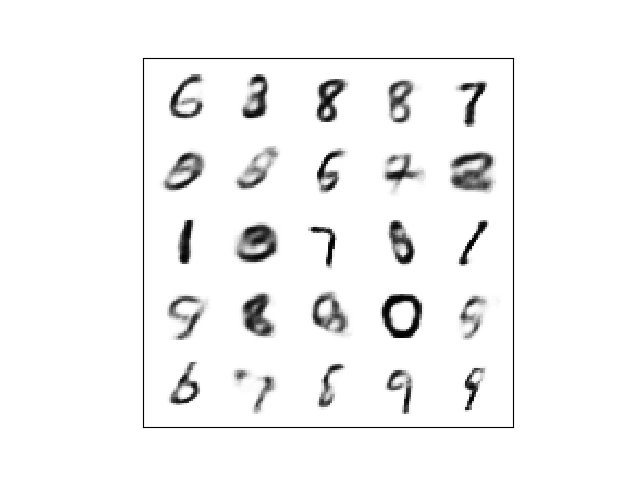

In [1]:
from IPython.display import Image
Image(filename='task_3_1.png') 

### Subtask 3.2:

We generate 10 image reconstructions using the recognition model and then the generative model. First, we choose the first 10 images from the test set and then, the reconstructions are obtained by generating $\pmb{z}$ using $q_\phi(\pmb{z}|\pmb{x}_i)$. Finally, we generates $\pmb{x}$ again using $p_\theta(\pmb{x}|\pmb{z})$.


In [ ]:
test_first_10_images = test_images[:10]
encoder_output = neural_net_predict(rec_params, test_first_10_images)
latent_variables_samples = sample_latent_variables_from_posterior(encoder_output)
decoder_output = neural_net_predict(gen_params, latent_variables_samples)

reconstruction_images = np.append(
                    test_first_10_images, 
                    sigmoid(decoder_output), 
                    axis = 0
                )

save_images(reconstruction_images, "task_3_2")

The images obtained are shown below:

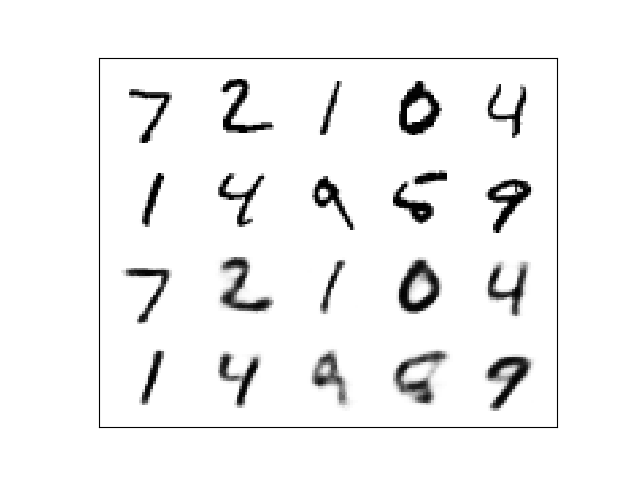

In [2]:
Image(filename='task_3_2.png') 

### Subtask 3.3:

We generate 5 interpolations in the latent space from one image to another. For that, we consider the first and second image in the test set, the third and fourth image in the test set and so on. 

To obtain the interpolations, we try to find the latent representation of each image considering only the mean of the predictive model $q(\pmb{z}|\pmb{x})$ and ignoring the variance. The interpolation is obtained by computing $\pmb{z}^s_{mix}$ = $\pmb{z}_1^s + (1 − s)\pmb{z}_2$ for $s\in[0, 1]$, where the latent representation of the first image is $\pmb{z}_1$ and the latent representation of the second image is $\pmb{z}_2$. 

Finally, for a grid of 25 values in the interval $[0, 1]$, we generate the corresponding image using $p_\theta(\pmb{x}|\pmb{z})$ given $\pmb{z}^s_{mix}$. 

In [ ]:
num_interpolations = 5
num_interpolation_steps = 25

for i in range(5):

    # Get first and second image to compute interpolations
    first_image = neural_net_predict(rec_params, [test_images[2*i]])
    second_image = neural_net_predict(rec_params, [test_images[2*i+1]])

    # Use mean of the recognition model as the latent representation.        
    D = np.shape(first_image)[1] // 2
    first_latents = np.array(first_image[:, :D])
    second_latents = np.array(second_image[:, :D])

    # Get interpolation scalars using a convex conbination
    S = np.linspace(0, 1, num_interpolation_steps)[::-1]
    interpolation = np.array([s*first_latents + (1-s)*second_latents for s in S])

    # Reshape to (num_interpolation_steps, n_features)
    interpolation = interpolation.reshape(num_interpolation_steps, -1)

    # Compute in latent space and save them using save images
    image = neural_net_predict(gen_params, interpolation)
    save_images(sigmoid(image), f"task_3_3_{i}")

The images obtained are shown below:

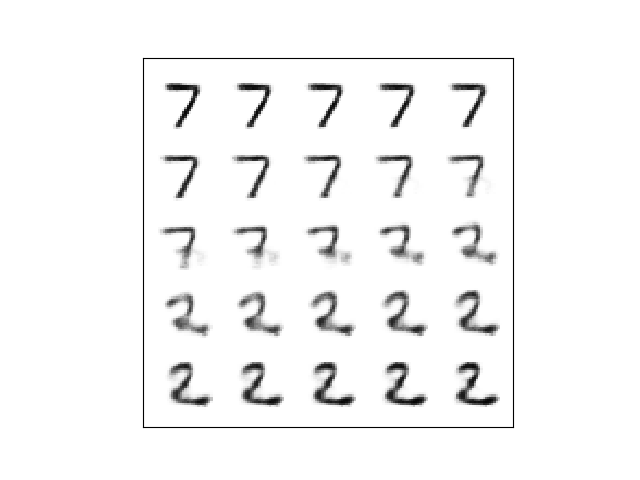

In [3]:
Image(filename='task_3_3_0.png') 